### Part 1 Wrap Up Summary

In part 1, I completed a C++ implementation for top 5 bid ask levels calculation

The implementation has key points:
1. Abstraction: Object oriented (order class, orderbook class)
<br/><br/>
2. Encapsulation: Separation of interface and implementation
    - User only interacts with the interface of orderbook to process orders
<br/><br/>
3. Resource memory management: 
    - dynamically allocated memory to store order and release after emptying orderbook
<br/><br/>
4. Error Handling:
    - While the given dataset does not have any data problem, will output error in cases such as adding duplicate orders or modifying/ deleting a non-existent order
<br/><br/>
5. Test cases to test the error handling



### Part 2 Modeling and Signal Generation

In [1]:
import pandas as pd
import numpy as np
data_06_10=pd.read_csv('output_final/output_res_20190610.csv',index_col=0)
data_06_11=pd.read_csv('output_final/output_res_20190611.csv',index_col=0)
data_06_12=pd.read_csv('output_final/output_res_20190612.csv',index_col=0)
data_06_13=pd.read_csv('output_final/output_res_20190613.csv',index_col=0)
data_06_14=pd.read_csv('output_final/output_res_20190614.csv',index_col=0)
all_data=[data_06_10,data_06_11,data_06_12,data_06_13,data_06_14]
dates=["20190610","20190611" ,"20190612" ,"20190613" ,"20190614"]

#### 2.1 Data Exploration and Sanity Checks

##### a. Trading Hours

We can see for all daily files similar as below, the timestamp begins at 0 and ends at 36000,000,000 for each trading day

This suggests that there are 10 hours (36000 seconds) of trading session for this hypothetical instrument. Timestamp measure is microseconds.

The time can be from 0am to 10am EST for a futures market

In [2]:
data_06_10.tail()

,price,side,bp0,bq0,bp1,bq1,bp2,bq2,bp3,bq3,...,ap1,aq1,ap2,aq2,ap3,aq3,ap4,aq4,total_bid_levels,total_ask_levels
timestamp,,,,,,,,,,,,,,,,,,,,,
35991588299,10025,b,10025.0,14,10020.0,74,10015.0,75,10010.0,174,...,10035.0,103,10040.0,91,10045.0,59,10050.0,13,2013,2663
35991591443,10025,b,10025.0,13,10020.0,74,10015.0,75,10010.0,174,...,10035.0,103,10040.0,91,10045.0,59,10050.0,13,2012,2663
35994717091,10050,a,10025.0,13,10020.0,74,10015.0,75,10010.0,174,...,10035.0,103,10040.0,91,10045.0,59,10050.0,14,2012,2664
35998622015,10070,a,10025.0,13,10020.0,74,10015.0,75,10010.0,174,...,10035.0,103,10040.0,91,10045.0,59,10050.0,14,2012,2665
36000000000,10010,b,10025.0,13,10020.0,74,10015.0,75,10010.0,173,...,10035.0,103,10040.0,91,10045.0,59,10050.0,14,2011,2665


##### b. Bid ask sanity check

We know from market microstructure that best bid cannot be higher than the best ask for an order book, or the order will be crossed

In [3]:
def check_bestbid_best_ask(data):
    temp=data[(data['ap0']!=0) & (data['bp0']!=0)]
    return sum(temp['bp0']>=temp['ap0'])

In our data, all days best bid is lower than best ask, pass sanity checks

In [4]:
count=0
for data in all_data:
    print(dates[count], "has", check_bestbid_best_ask(data), "observations where best ask is less than best bid")
    count+=1

20190610 has 0 observations where best ask is less than best bid
20190611 has 0 observations where best ask is less than best bid
20190612 has 0 observations where best ask is less than best bid
20190613 has 0 observations where best ask is less than best bid
20190614 has 0 observations where best ask is less than best bid


##### c. Trading Activity Throughout the day

For a normal futures hour trading session, trading volume spikes during open and closing hours. So we should see a volume trading activities smile from a actual futures contract

However, in our given instrument, the data seems to be centered in the middle. The rest of 6/11-6/14 are even more random pattern. This suggests that the data may be simulated.

Text(0.5, 1.0, 'Figure 1. Trading Activities throughout the day of 6/10')

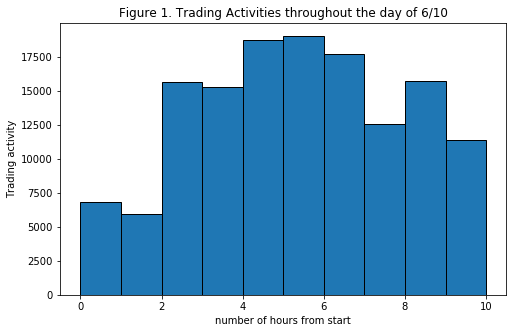

In [5]:
import matplotlib.pyplot as plt

# Generating a bin plot (histogram) from the Series
plt.figure(figsize=(8, 5))
plt.hist(data_06_10.index/1000000/60/60, bins=10, edgecolor='black')  # Adjust the number of bins as needed (here: 10 bins)
plt.xlabel('number of hours from start')
plt.ylabel('Trading activity')
plt.title('Figure 1. Trading Activities throughout the day of 6/10')

Figure 2. trading activity chart from 6/11-6/14


Text(0.5, 1.0, '06/14')

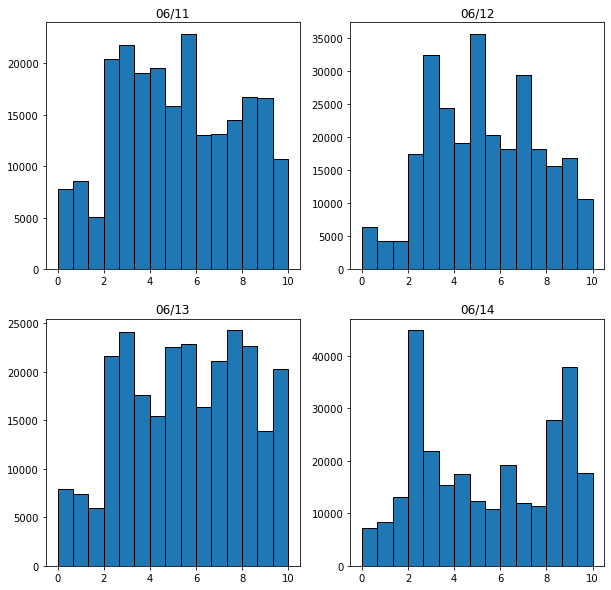

In [67]:
print('Figure 2. trading activity chart from 6/11-6/14')
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
axs[0, 0].hist(data_06_11.index/1000000/60/60, bins=15, edgecolor='black')  # Adjust the number of bins as needed (here: 10 bins)
axs[0, 1].hist(data_06_12.index/1000000/60/60, bins=15, edgecolor='black')
axs[1, 0].hist(data_06_13.index/1000000/60/60, bins=15, edgecolor='black')
axs[1, 1].hist(data_06_14.index/1000000/60/60, bins=15, edgecolor='black')
axs[0, 0].set_title('06/11')
axs[0, 1].set_title('06/12')
axs[1, 0].set_title('06/13')
axs[1, 1].set_title('06/14')


Also as a demonstration, here is how **quickly** the bid and ask level changes in two seconds

Text(0.5, 1.0, 'The change of best bid and best ask level in 2 seconds')

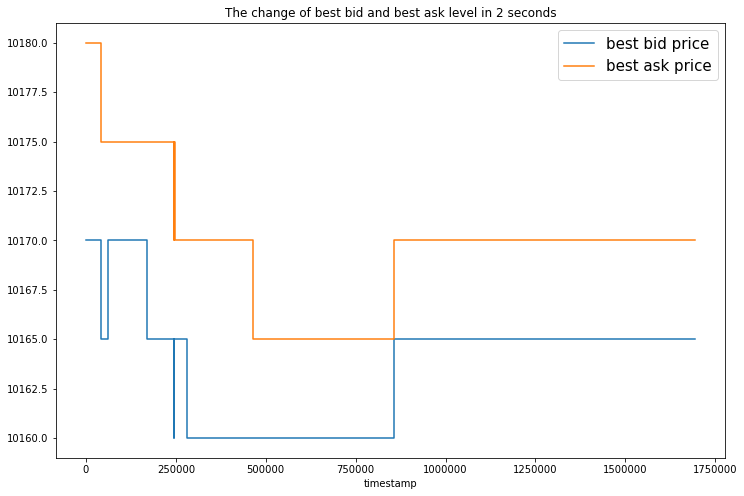

In [326]:
ax=data_06_11['bp0'][200:650].plot(label="best bid price",figsize=(12,8),drawstyle="steps-post")
data_06_11['ap0'][200:650].plot(label="best ask price",ax=ax,drawstyle="steps-post")
ax.legend(fontsize="15")
ax.set_title("The change of best bid and best ask level in 2 seconds")

#### 2.2 Microstructure feature calculation

- Calculate a collection of predictive features for use

    - **spread**: best bid price - best ask price

        bigger spread may mean reversion as buyers or seller are less intended to cross spread

    - **order weighted micro price**
        $$\omega=\sqrt{N_A} + \sqrt{N_B}$$
         $$OWA=\frac{\sqrt{N_A}}{\omega} B + \frac{\sqrt{N_B}}{\omega} A$$


    - **order imbalance approximate**(5, 10, 20min):
      
        $$\frac{new buy activities - new sell activities}{new buy activities + new sell activities}
    
    - **best bid quantity / sum of Top 5 Bid quantity**

    - **best ask quantity / sum of Top 5 ask quantity**

    - **best bid quantity / sum of Top 5 bid quantity**

    - **best bid quantity + best ask quantity**
            Is the book especially thin or thick right now

    - **time of day**

    - **total bid/ask quantity across all levels**

    - **previous 5/10/20 min return**
    

In [302]:
import datetime as dt
def generate_final_features_df(data, month, day):
    data=data.copy()
    data['spread']=data['ap0']-data['bp0']
    data['sqrt_weighted']=np.sqrt(data['bq0'])+np.sqrt(data['aq0'])
    data['owa']=np.sqrt(data['aq0'])/data['sqrt_weighted'] * data['bp0']+np.sqrt(data['bq0'])/data['sqrt_weighted'] * data['ap0']
    data['bid_q_percentage']=data['bq0']/(data['bq0']+data['bq1']+data['bq2']+data['bq3']+data['bq4'])
    data['ask_q_percentage']=data['aq0']/(data['aq0']+data['aq1']+data['aq2']+data['aq3']+data['aq4'])
    data['top_book_size']=data['aq0']+data['bq0']
    data['is_buy']=np.where(data['side']=="b",1,0)
    data['is_sell']=np.where(data['side']=="a",1,0)
    data['tod']=data.index/1000
    data['total_order_imbalance']=(data['total_ask_levels']-data['total_bid_levels'])/(data['total_ask_levels']+data['total_bid_levels'])
    data['final_timestamp']=dt.datetime(2019,month,day,0,0)+data['tod'].astype('timedelta64[ms]')
    data.set_index('final_timestamp',inplace=True)
    data['5min_imbalance']=(data['is_buy'].rolling('5min').sum()-data['is_sell'].rolling('5min').sum())/(data['is_buy'].rolling('5min').sum()+data['is_sell'].rolling('5min').sum())
    data['10min_imbalance']=(data['is_buy'].rolling('10min').sum()-data['is_sell'].rolling('10min').sum())/(data['is_buy'].rolling('10min').sum()+data['is_sell'].rolling('10min').sum())
    data['20min_imbalance']=(data['is_buy'].rolling('20min').sum()-data['is_sell'].rolling('20min').sum())/(data['is_buy'].rolling('20min').sum()+data['is_sell'].rolling('20min').sum())
    data=data.resample('1min').last()
    data['20minprevious_rtn']=data['owa']/data['owa'].shift(20)-1
    data['10minprevious_rtn']=data['owa']/data['owa'].shift(10)-1
    data['5minprevious_rtn']=data['owa']/data['owa'].shift(5)-1
    data['1minprevious_rtn']=data['owa']/data['owa'].shift(1)-1
    data['bidoverask_percentage']=data['bid_q_percentage']/data['ask_q_percentage']
    data['previous_spread']=data['spread'].shift(1)
    data['next_spread']=data['spread'].shift(-1)
    data['5minfwd_rtn']=data['owa'].shift(-5)/data['owa']-1
    data['1minfwd_rtn']=data['owa'].shift(-1)/data['owa']-1
    data['10minfwd_rtn']=data['owa'].shift(-10)/data['owa']-1
    data['20minfwd_rtn']=data['owa'].shift(-20)/data['owa']-1
    return data

In [303]:
data_06_10=generate_final_features_df(data_06_10,6,10)
data_06_11=generate_final_features_df(data_06_11,6,11)
data_06_12=generate_final_features_df(data_06_12,6,12)
data_06_13=generate_final_features_df(data_06_13,6,13)
data_06_14=generate_final_features_df(data_06_14,6,14)

**Train test split**

- keep the 20190614 data as testing set and the previous 4 days as training set

In [304]:
training_data=pd.concat([data_06_10,data_06_11,data_06_12,data_06_13]).dropna()
test_data=data_06_14.dropna()

#### 2.3 Subsampling data - regularizing the irregular time series

- data granularity

I strongly recommend subsampling the data to 1min intervals.

My reason is when we look at the order book update which comes at irregular time intervals. We do not have enough granularity for the data to distinguish every tick, unless we plan cetainly to trade on every tick or event.

In short, we should subsample the data because if we want to potentially trade on every tick/event, it would require us to calculate the time elapsed since the last tick. We don't have enough data granularity for that purpose

As showed below, the first few trades of 6/11 are all timestamped 0.

In [12]:
data_06_11.head()

,price,side,bp0,bq0,bp1,bq1,bp2,bq2,bp3,bq3,...,ap1,aq1,ap2,aq2,ap3,aq3,ap4,aq4,total_bid_levels,total_ask_levels
timestamp,,,,,,,,,,,,,,,,,,,,,
0,10180,a,0.0,0,0.0,0,0.0,0,0.0,0,...,0.0,0,0.0,0,0.0,0,0.0,0,0,99
0,10180,a,0.0,0,0.0,0,0.0,0,0.0,0,...,0.0,0,0.0,0,0.0,0,0.0,0,0,100
0,10185,a,0.0,0,0.0,0,0.0,0,0.0,0,...,10185.0,1,0.0,0,0.0,0,0.0,0,0,101
0,10170,b,10170.0,1,0.0,0,0.0,0,0.0,0,...,10185.0,1,0.0,0,0.0,0,0.0,0,1,101
0,10185,a,10170.0,1,0.0,0,0.0,0,0.0,0,...,10185.0,2,0.0,0,0.0,0,0.0,0,1,102


#### 2.3 Prediction Target

There may be two prediction targets
- the most useful for trading is to predict **forward return**

- We can also predict **spread** for execution costs prediction


forward return are definitely most useful for trading the product, we can assume a fixed holding horizon like 5 minute of 10 minute. Ideally, a strong alpha should allow us to have positive return over the next 5-10 minutes.

However, we are using order book infomation now, which only represent the intention to buy/sell. It may not sufficient to predict the forward returns

As showed below in the correlation heat map, the forward return last three rows has quite low correlaton to the features. However, the next minute spread shows some correlation(around 0.15) to the imbalance features

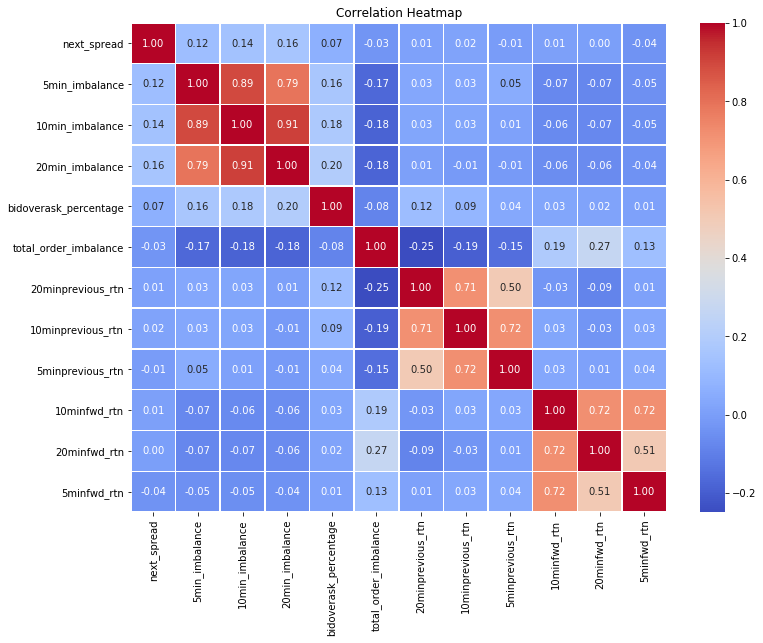

In [305]:
correlation_matrix=training_data[['next_spread','5min_imbalance','10min_imbalance','20min_imbalance','bidoverask_percentage','total_order_imbalance','20minprevious_rtn','10minprevious_rtn','5minprevious_rtn','10minfwd_rtn','20minfwd_rtn','5minfwd_rtn']].corr()
import seaborn as sns
plt.figure(figsize=(12, 9))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

We will test both prediction targets.

in construction of the 5min forward return. There are several ways,
we can use the following prices to measure the forward return
- mid quote: 
    - this is better than the last trades price as it incorporates the spread into the prices. Entry would incorporate crossing half of the spread
<br></br>
- vwap:
    - In practice, we cannot ensure that we will execute at that exact price. VWAP return can help us better estimate the execution price in an interval. The problem is we do not have trade prices here only order updates.
<br></br>
- order weight average prices:

    - I choose this approach as it best incorpates both the spread and the price impact movement of the potential execution. The intuitive is if a top bid quote has a small size it is easier for the seller to cross the bid that moves the price level.



#### 2.4 Lasso Regression to predict forward returns

In [308]:
X_train=training_data[['spread','5min_imbalance','10min_imbalance','20min_imbalance','bidoverask_percentage','total_order_imbalance','20minprevious_rtn','10minprevious_rtn','5minprevious_rtn']]
y_train=training_data['20minfwd_rtn']
X_test=test_data[['spread','5min_imbalance','10min_imbalance','20min_imbalance','bidoverask_percentage','total_order_imbalance','20minprevious_rtn','10minprevious_rtn','5minprevious_rtn']]
y_test=test_data['20minfwd_rtn']

Below we show the correlation heat map of the features and our prediction target, the last 3 rows and columns are the predicted returns.

20min forward returns seems to be the best predicted variable, but still low in correlation to the features

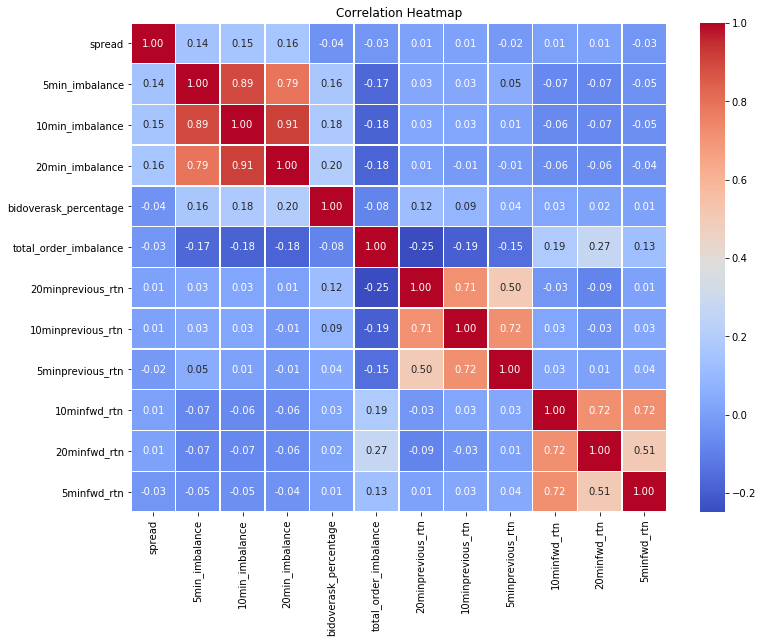

In [260]:
import seaborn as sns
plt.figure(figsize=(12, 9))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

The prediction R2 for forward returns is actually negative. This suggests that forward returns are indeed not the appropriate target variable.

In [311]:
from sklearn.linear_model import LassoCV, Lasso
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

alphas = np.logspace(-4, 4, 100)
lasso_cv = LassoCV(alphas=alphas, cv=5)  # 5-fold cross-validation

# Fit the model to the training data
lasso_cv.fit(X_train, y_train)
optimal_alpha = lasso_cv.alpha_

lasso_final = Lasso(alpha=optimal_alpha)
lasso_final.fit(X_train, y_train)
y_pred = lasso_final.predict(X_test)

# Calculate r2  on the test set
mse = r2_score(y_test, y_pred)
print(f"R2 score on test set using optimal alpha: {mse:.8f}")

R2 score on test set using optimal alpha: -0.00858844


#### 2.5 Lasso Regression to predict spread

In [313]:
X_train=training_data[['previous_spread','5min_imbalance','10min_imbalance','20min_imbalance','bidoverask_percentage','total_order_imbalance','20minprevious_rtn','10minprevious_rtn','5minprevious_rtn']]
y_train=training_data['spread']
X_test=test_data[['previous_spread','5min_imbalance','10min_imbalance','20min_imbalance','bidoverask_percentage','total_order_imbalance','20minprevious_rtn','10minprevious_rtn','5minprevious_rtn']]
y_test=test_data['spread']


alphas = np.logspace(-4, 4, 100)
lasso_cv = LassoCV(alphas=alphas, cv=5)  # 5-fold cross-validation

# Fit the model to the training data
lasso_cv.fit(X_train, y_train)
optimal_alpha = lasso_cv.alpha_
lasso_final = Lasso(alpha=optimal_alpha)
lasso_final.fit(X_train, y_train)
y_pred = lasso_final.predict(X_test)

# Calculate Mean Squared Error (MSE) on the test set
mse = r2_score(y_test, y_pred)

The prediction R2 for spread is better than the forward returns. This suggests that spread may be a better predicted variable.

In [314]:
print(f"R2 score on test set using optimal alpha: {mse:.8f}")

R2 score on test set using optimal alpha: 0.01725266


#### 2.6 Signal from Lasso Regression to predict spread

In order to use the regression result, we can create signal so that when the predicted spread is extremely wide, refrain from trading low alpha signals(i.e increase the threshold of triggering signal)

The signal is likely to combine with other signals to have practical impact in execution.